# **Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/PlantClassification

/content/drive/MyDrive/PlantClassification


# **Importing Libraries**

In [4]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 

In [5]:
import gradio as gr
import numpy as np
import pickle
import cv2
import os

from os import listdir
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils import img_to_array
from keras.models import Sequential
from keras.models import load_model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K

# **Loading Dataset**

In [6]:
model_dir = 'Trained Models/Model.pkl'
label_dir = 'Trained Models/Label Transform.pkl'
train_dir = 'dataset/train'
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
width=64
height=64
depth=3
# Number of images used to train the model
N_IMAGES = 300
model = None

In [7]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [8]:
def dataProcessing():
    image_list, label_list = [], []
    try:
        print("[INFO] Loading Images ...")

        plant_disease_folder_list = listdir(train_dir)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

            for image in plant_disease_image_list[:N_IMAGES]:
                image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True or image_directory.endswith(".JPEG") or image_directory.endswith(".jpeg"):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

        print("[INFO] Loading Image...")
    except Exception as e:
        print(f"Error : {e}")


    image_size = len(image_list)
    np_image_list = np.array(image_list, dtype=np.float16) / 255.0

    print(f"Total Number of Images: {image_size}")

    print("[INFO] Image Loading Completed")

    label_binarizer = LabelBinarizer()
    image_labels = label_binarizer.fit_transform(label_list)
    pickle.dump(label_binarizer,open(label_dir, 'wb'))
    n_classes = len(label_binarizer.classes_)

    print(f"Total Number of Classes: {n_classes}")

    return np_image_list,image_labels

# **Training Model And Plotting**

In [9]:
def trainModel():

    np_image_list,image_labels=dataProcessing()

    print("[INFO] Spliting Data to train & test")

    x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

    aug = ImageDataGenerator(
                rotation_range=25, width_shift_range=0.1,
                height_shift_range=0.1, shear_range=0.2,
                zoom_range=0.2,horizontal_flip=True,
                fill_mode="nearest")
    global model
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(filters=32,kernel_size=(5,5),activation='relu',padding='same',input_shape=inputShape))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(39,activation='softmax'))

    model.summary()

    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    # train the network
    print("[INFO] Training Network...")


    history = model.fit(
        aug.flow(x_train, y_train, batch_size=BS),
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train) // BS,
        epochs=EPOCHS, verbose=1)


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

    print("[INFO] Calculating Model Accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

    # Pickle the trained model
    #pickle.dump(model, open('Trained Models/Model.pkl', 'wb'))
    acc_text = 'Accuracy is: ' + (str(acc))

    # Pickle the trained model
    pickle.dump(model, open(model_dir, 'wb'))
    model.save('Trained Models/model.h5')

[INFO] Loading Images ...
[INFO] Processing Tomato Tomato Yellow Leaf Curl Virus ...
[INFO] Processing Tomato Spider Mites Two-Spotted Spider Mite ...
[INFO] Processing Tomato Target Spot ...
[INFO] Processing Tomato Tomato Mosaic Virus ...
[INFO] Processing Tomato Septoria Leaf Spot ...
[INFO] Processing Tomato Late Blight ...
[INFO] Processing Tomato Early Blight ...
[INFO] Processing Tomato Bacterial Spot ...
[INFO] Processing Tomato Leaf Mold ...
[INFO] Processing Tomato Healthy ...
[INFO] Processing Strawberry Leaf Scorch ...
[INFO] Processing Soybean Healthy ...
[INFO] Processing Squash Powdery Mildew ...
[INFO] Processing Strawberry Healthy ...
[INFO] Processing Raspberry Healthy ...
[INFO] Processing Potato Early Blight ...
[INFO] Processing Potato Healthy ...
[INFO] Processing Pepperbell Healthy ...
[INFO] Processing Potato Late Blight ...
[INFO] Processing Pepperbell Bacterial Spot ...
[INFO] Processing Peach Healthy ...
[INFO] Processing Orange Haunglongbing (Citrus Greening

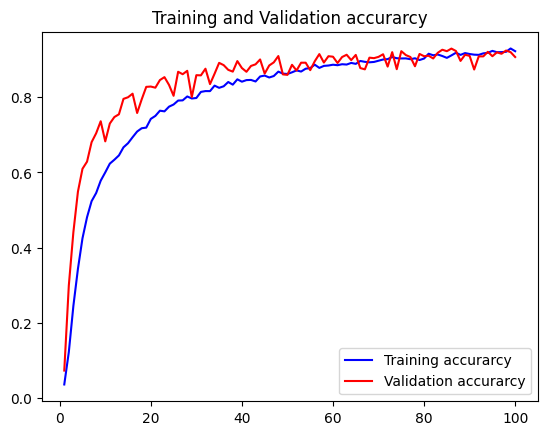

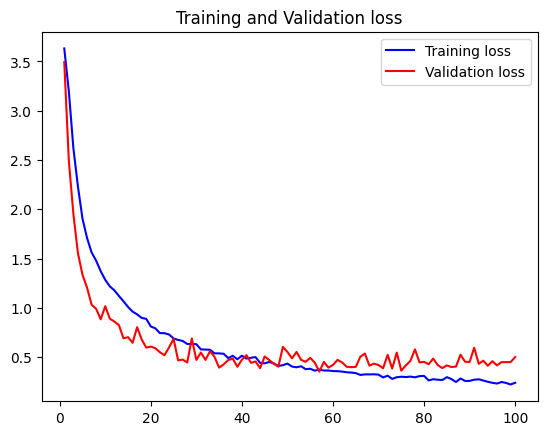

[INFO] Calculating Model Accuracy
73/73 [==============================] - 0s 6ms/step - loss: 0.5015 - accuracy: 0.9065
Test Accuracy: 90.6505823135376


In [ ]:
trainModel()

# **Predicting Disease**

In [10]:
def classifyDisease(image_path):
    global model
    if model is None:
        print("[INFO] Loading Model")
        #model = pickle.load(open(model_dir, 'rb'))
        model = load_model('Trained Models/model.h5')
    else:
        print("[INFO] Previously Loaded Model is used")

    image_labels = pickle.load(open(label_dir, 'rb'))

    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    predict_x=model.predict(np_image)
    classes_x=np.argmax(predict_x,axis=1)
    result = classes_x
    resultClass=image_labels.classes_[result]
    #print (result)
    print (resultClass)
    return resultClass

# **Interface Gradio**

In [11]:
with gr.Blocks() as PDC:
    gr.Markdown("Plant Disease Classifer")

    with gr.Tab("Predict Disease"):
        with gr.Row():
            image_input = gr.Image(type="filepath",label="Image")
            text_output = gr.Textbox(label="Plant Disease")
        predict_button = gr.Button("Predict")

    predict_button.click(classifyDisease, inputs=image_input, outputs=text_output)
PDC.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>